# Analysis of the gills
- Oleksiy and Flu scanned them
- Dea delineated them
- David does the analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn
seaborn.set_style('dark')
try:
    from matplotlib_scalebar.scalebar import ScaleBar
except:
    print('No scalebars')
import os
import platform
import pandas
import glob
import scipy.misc
import imageio
import scipy.stats
import numpy
import skimage.filters
import skimage.morphology
import gc
import warnings
warnings.filterwarnings("ignore")

In [2]:
# My figure defaults
plt.rc('image', cmap='gray', interpolation='nearest')  # Display all images in b&w and with 'nearest' interpolation
plt.rcParams['figure.figsize'] = (16, 9)  # Size up figures a bit
plt.rcParams["savefig.transparent"] = False

In [3]:
# Setup scale bar
plt.rcParams['scalebar.location'] = 'lower right'
plt.rcParams['scalebar.frameon'] = False
plt.rcParams['scalebar.color'] = 'white'

In [4]:
def get_git_hash():
    """
    Get the current git hash from the repository.
    Based on http://stackoverflow.com/a/949391/323100 and
    http://stackoverflow.com/a/18283905/323100
    """
    from subprocess import Popen, PIPE
    import os
    gitprocess = Popen(['git', '--git-dir', os.path.join(os.getcwd(), '.git'),
                        'rev-parse', '--short', '--verify', 'HEAD'],
                       stdout=PIPE)
    (output, _) = gitprocess.communicate()
    return output.strip().decode("utf-8")

In [5]:
def get_pixelsize(logfile):
    """Get the pixel size from the scan log file"""
    with open(logfile, 'r') as f:
        for line in f:
            if 'Image Pixel' in line and 'Scaled' not in line:
                pixelsize = float(line.split('=')[1])
    return(pixelsize)

In [6]:
# Work on the fast SSD from here on!
FastSSD = True
if 'debian' in platform.dist():
    if FastSSD:
        StartDir = '/media/habi/Fast_SSD/'
    else:
        StartDir = '/media/habi/Blue Seagate/'
else:
    if FastSSD:
        StartDir = 'F:/'
    else:
        StartDir = 'G:/'
RootFolder = os.path.join(StartDir, 'Zebra-Fish_Matthias')

In [7]:
print('We are loading all the data from %s' % RootFolder)

We are loading all the data from /media/habi/Fast_SSD/Zebra-Fish_Matthias


In [8]:
# Make directory for output
OutPutDir = os.path.join(os.getcwd(), 'Output', get_git_hash())
print('We are saving the output images to %s' % OutPutDir)
os.makedirs(OutPutDir, exist_ok=True)

We are saving the output images to /home/habi/P/Documents/Zebrafish-Gills/Output/82436ab


In [9]:
# Display all plots identically
lines = 5
# And then do something like
# plt.subplot(lines, numpy.ceil(len(ROIFolder) / float(lines)), c + 1)

Let's get going, now that we set up everything...

In [10]:
# Get a list of all the samples we scanned
SampleNames = sorted(next(os.walk(RootFolder))[1])

In [11]:
# Remove Folder we don't want
if not FastSSD:
    SampleNames.remove('Original SEM Bilder')
    SampleNames.remove('tresholding_estimation')

In [12]:
# Save all the information into a pandas dataframe
Data = pandas.DataFrame({'Sample': SampleNames})
Data['Folder'] = [os.path.join(RootFolder, s) for s in SampleNames]
Data['LogFile'] = [sorted(glob.glob(os.path.join(f, 'proj', '*.log')))[0] for f in Data.Folder]
Data['RecFolder'] = [os.path.join(RootFolder, f, 'rec') for f in Data.Folder]
Data['VOIFolder'] = [os.path.join(RootFolder, f, 'VOI') for f in Data.Folder]
Data['OverviewName'] = [glob.glob(os.path.join(r, '*spr.bmp'))[0] for r in Data.RecFolder]
Data['ReconstructionNames'] = [sorted(glob.glob(os.path.join(r, '*.png'))) for r in Data.RecFolder]
# Try to be a bit clever with loading the VOI slices
# They are saved as either PNG or BMP, and there's also some other stuff in the folder...
Data['VOINames'] = [sorted(glob.glob(os.path.join(r, '*rec*[0123456789].*'))) for r in Data.VOIFolder]

In [13]:
# Make an 'experiment' column, which we use for the box plots below
def whichexperiment(i):
    '''Categorize  into 'Swimmer' or 'Control' '''
    if 'immer' in i:
        return 'Swimmer'
    if 'ontrol' in i:
        return 'Control'

In [14]:
Data['Experiment'] = [whichexperiment(name) for name in Data.Folder]

In [15]:
# Color plot based on label (mrt, ctrl or bb)
def color_based_on_experiment(i):
    '''Colorize into 'Swimmer' or 'Control' '''
    if 'ontrol' in i:
        return seaborn.color_palette()[0]
    if 'immer' in i:
        return seaborn.color_palette()[1]

In [16]:
Data['Color'] = [color_based_on_experiment(name) for name in Data.Folder]

In [17]:
# Read the xls-sheet I got from Matthias with the fish data
# I've copied the relevant data to a new sheet
datafile = glob.glob('G*.xlsx')[0]
xl = pandas.ExcelFile(datafile)
length = xl.parse("size_after")
Data['Length'] = pandas.concat([length.Control, length.Swimmers], ignore_index=True)

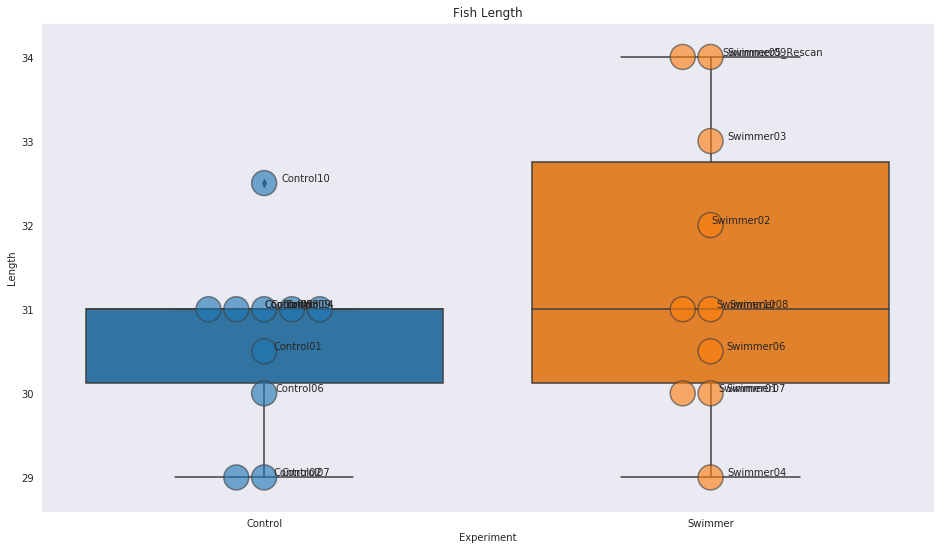

In [28]:
# Boxplot of the length
seaborn.boxplot(data=Data, x='Experiment', y='Length')
seaborn.swarmplot(data=Data, x='Experiment', y='Length', s=25, linewidth=1.5, alpha=0.618)
label=True
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Length[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Length[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Fish Length')
plt.savefig(os.path.join(OutPutDir, 'fishlength.png'))
plt.show()

In [29]:
# Get Pixel sizes of the scans
Data['PixelSize'] = [get_pixelsize(logfile) for logfile in Data.LogFile]

In [30]:
Data.head()

,Sample,Folder,LogFile,RecFolder,VOIFolder,OverviewName,ReconstructionNames,VOINames,Experiment,Color,Length,PixelSize
0,Control01,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[],[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",30.5,1.660000
1,Control02,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[],[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",29.0,1.650013
2,Control03,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[],[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",31.0,1.650013
3,Control04,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[],[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",31.0,1.660000
4,Control05,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,/media/habi/Fast_SSD/Zebra-Fish_Matthias/Contr...,[],[/media/habi/Fast_SSD/Zebra-Fish_Matthias/Cont...,Control,"(0.12156862745098039, 0.4666666666666667, 0.70...",31.0,1.660000


In [31]:
# Load Overviews (not into the dataframe, to keep things speedy)
Overviews = [imageio.imread(o) for o in Data.OverviewName]

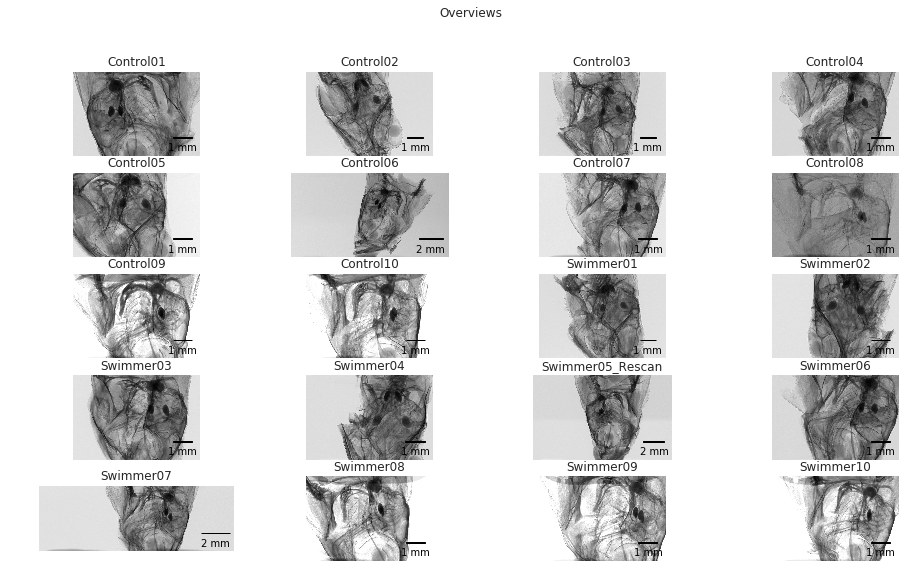

In [33]:
# Display overviews (shadow projections)
for c, o in enumerate(Overviews):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(o)
    try:
        plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um', color = 'black'))
    except:
        pass
    plt.axis('off')
    plt.title('%s' % Data.Sample[c])
plt.suptitle('Overviews')
plt.savefig(os.path.join(OutPutDir, 'Overviews.png'))
plt.show()

In [34]:
# Convert *all* VOI slices into single NumPy arrays and save them to disk
# But only do this if we didn't do it already :)
# Partially based on http://stackoverflow.com/a/39195332/323100
# Since we reload/memorymap the stack below again, we overwrite the variable with NAN and clear the memory
Data['OutputNameVOI'] = [os.path.join(f, sample + '_VOI.npy') for f, sample in zip(Data.Folder, Data.Sample)]
# Don't save into the dataframe, or else we won't be able to make it :)
VOIImages = [numpy.nan for file in Data.OutputNameVOI]
for c, voi in enumerate(Data.OutputNameVOI):   
    # Only do this if we didn't do it already...
    if os.path.exists(voi):
        print('%2s/%s: %16s: Already saved to %s' % (c+1, len(Data.Sample), Data.Sample[c], voi[len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Reading %4s VOI images' % (c+1,len(Data.Sample), Data.Sample[c], len(Data.VOINames[c])))
        # Actually load the images now
        VOIImages[c] = numpy.array([scipy.misc.imread(i, flatten = True) for i in Data.VOINames[c]])
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%23s: Saving to %s' % (Data.Sample[c], voi))
        numpy.save(voi, VOIImages[c], allow_pickle=False)
        # Clear memory 
        VOIImages[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_VOI.npy
 2/20:        Control02: Already saved to /Control02/Control02_VOI.npy
 3/20:        Control03: Already saved to /Control03/Control03_VOI.npy
 4/20:        Control04: Already saved to /Control04/Control04_VOI.npy
 5/20:        Control05: Already saved to /Control05/Control05_VOI.npy
 6/20:        Control06: Already saved to /Control06/Control06_VOI.npy
 7/20:        Control07: Already saved to /Control07/Control07_VOI.npy
 8/20:        Control08: Already saved to /Control08/Control08_VOI.npy
 9/20:        Control09: Already saved to /Control09/Control09_VOI.npy
10/20:        Control10: Already saved to /Control10/Control10_VOI.npy
11/20:        Swimmer01: Already saved to /Swimmer01/Swimmer01_VOI.npy
12/20:        Swimmer02: Already saved to /Swimmer02/Swimmer02_VOI.npy
13/20:        Swimmer03: Already saved to /Swimmer03/Swimmer03_VOI.npy
14/20:        Swimmer04: Already saved to /Swimmer04/Swimmer04_VOI.npy
15/20:

In [35]:
# Free the memory of the images we loaded.
# We 'memory-map' them again below
%xdel VOIImages

In [36]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
VOIImages = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]

In [37]:
# Get ourselves the middle slice to show
Data['MiddleSliceName'] = [n[len(n)//2] for n in Data.VOINames]
Data['MiddleSlice'] = [i[len(i)//2] for i in VOIImages]

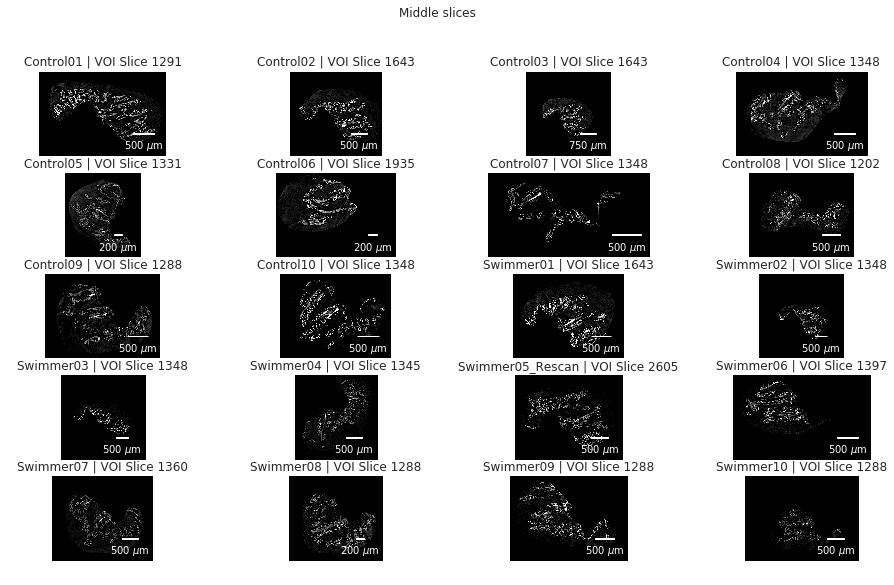

In [38]:
# Display the middle slice of the VOI
for c, m in enumerate(Data.MiddleSlice):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.imshow(m, vmax=0.618 * numpy.max(m))
    plt.title('%s | VOI Slice %s' % (Data.Sample[c], os.path.basename(Data.MiddleSliceName[c])[-8:-4]))
    try:
        plt.gca().add_artist(ScaleBar(Data.PixelSize[c], 'um'))
    except:
        pass
    plt.axis('off')
plt.suptitle('Middle slices')
plt.savefig(os.path.join(OutPutDir, 'middleslices.png'))
plt.show()

In [39]:
Data['NumberOfVOISlices'] = [len(v) for v in Data.VOINames]

In [40]:
# Get the shape of the VOI
Data['VOIShape'] = [voi.shape for voi in VOIImages]
Data['VOIVolume'] = [shape[0]*shape[1]*shape[2] for shape in Data.VOIShape]

In [41]:
# Check of VOI size and number of files is consistent.
for i in range(20):
    if len(Data.VOINames[i]) != len(VOIImages[i]):
        print(Data.Sample[i])
        print(len(Data.VOINames[i]))
        print(Data.VOIShape[i][0])
        print(len(VOIImages[i]))
        print(80*'-')

In [42]:
# For bragging reasons in the manuscript
# All VOIs
Data[['Sample', 'VOIVolume', 'VOIShape',]].sort_values('VOIVolume', ascending=True)

,Sample,VOIVolume,VOIShape
6,Control07,3765644288,"(2452, 896, 1714)"
9,Control10,4529677680,"(2452, 1188, 1555)"
4,Control05,4590842238,"(2642, 1389, 1251)"
8,Control09,4825205744,"(2572, 1174, 1598)"
17,Swimmer08,4959042336,"(2572, 1317, 1464)"
5,Control06,5230802885,"(3389, 1045, 1477)"
0,Control01,5289930744,"(2338, 1227, 1844)"
15,Swimmer06,5717191800,"(2550, 1172, 1913)"
3,Control04,5936238056,"(2452, 1246, 1943)"
7,Control08,5963205600,"(2400, 1419, 1751)"


In [43]:
# The smallest VOIs
Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape',]].sort_values('VOIVolume', ascending=True).head(1)

,Sample,VOIVolume,NumberOfVOISlices,VOIShape
6,Control07,3765644288,2452,"(2452, 896, 1714)"


In [44]:
# For bragging reasons in the manuscript
# The largest VOIs
Data[['Sample', 'VOIVolume', 'NumberOfVOISlices', 'VOIShape',]].sort_values('VOIVolume', ascending=True).tail(1)

,Sample,VOIVolume,NumberOfVOISlices,VOIShape
2,Control03,19506703712,3062,"(3062, 2524, 2524)"


In [46]:
# Use a manageable amount of equally spaced slices for thresholding and MIP-ing
# NumberOfImagesToShow = 6
# NumberOfImagesToShow = 16
# NumberOfImagesToShow = 111
# NumberOfImagesToShow = 222
# NumberOfImagesToShow = 350
# NumberOfImagesToShow = 1111
NumberOfImagesToShow = Data.NumberOfVOISlices.max()  # just use all of them...

In [47]:
# Generate the subset information
Data['PrintEverySlice'] = [int(round(len(r)/NumberOfImagesToShow)) for r in Data.VOINames]
Data['SubsetNames']= [rn[::sw] for rn, sw in zip(Data.VOINames, Data.PrintEverySlice)]
for c, i in enumerate(Data.Sample):
    print('For %s we are working with a subset of %s (%0.1f %% of totally %s) equally '
          'spaced slices' % (i, len(Data.SubsetNames[c]), len(Data.SubsetNames[c]) / len(Data.VOINames[c]) * 100, 
                             len(Data.VOINames[c])))

For Control01 we are working with a subset of 2338 (100.0 % of totally 2338) equally spaced slices
For Control02 we are working with a subset of 3062 (100.0 % of totally 3062) equally spaced slices
For Control03 we are working with a subset of 3062 (100.0 % of totally 3062) equally spaced slices
For Control04 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Control05 we are working with a subset of 2642 (100.0 % of totally 2642) equally spaced slices
For Control06 we are working with a subset of 3389 (100.0 % of totally 3389) equally spaced slices
For Control07 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Control08 we are working with a subset of 2400 (100.0 % of totally 2400) equally spaced slices
For Control09 we are working with a subset of 2572 (100.0 % of totally 2572) equally spaced slices
For Control10 we are working with a subset of 2452 (100.0 % of totally 2452) equally spaced slices
For Swimme

In [48]:
# Put len of 'UseThis' into dataframe
Data['NumberOfAnalyzedVOISlices'] = [len((a)) for a in Data.SubsetNames]

In [49]:
# Calculate the thresholds of each slice
Data['OutputNameThreshold'] = [os.path.join(f,
                                            sample +  '_thresholds_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                    len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
Data['Threshold'] = [[numpy.nan] for s in Data.Sample]
for c, thresholdname in enumerate(Data.OutputNameThreshold):
    if os.path.exists(thresholdname):
        print('%2s/%s: %16s: Grab values from %s' % (c+1,
                                                     len(Data),
                                                     Data.Sample[c],
                                                     thresholdname[len(RootFolder):]))
        Data['Threshold'][c] = numpy.load(thresholdname)
    else:
        print('%2s/%s: %16s: Calculating thresholds for %s of %4s files' % (c+1,
                                                                            len(Data), Data.Sample[c],
                                                                            len(Data.VOINames[c][::Data.PrintEverySlice[c]]),
                                                                            len(Data.VOINames[c])))
        Data['Threshold'][c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
        for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
            try:
                # Calculate and save threshold (of only the image, e.g. img[img>0])
                Data['Threshold'][c][d] = skimage.filters.threshold_otsu(image[image>0])
            except (ValueError):
                # Save NAN if we can't calculate a threshold
                Data['Threshold'][c][d] = numpy.nan
        print('%23s: Saving thresholds to %s' % (Data.Sample[c], thresholdname[len(RootFolder):]))                
        numpy.save(thresholdname, Data.Threshold[c], allow_pickle=False)
        Data.Threshold[c] = numpy.nan
        gc.collect()

 1/20:        Control01: Grab values from /Control01/Control01_thresholds_from_2338_of_2338_slices.npy
 2/20:        Control02: Grab values from /Control02/Control02_thresholds_from_3062_of_3062_slices.npy
 3/20:        Control03: Grab values from /Control03/Control03_thresholds_from_3062_of_3062_slices.npy
 4/20:        Control04: Grab values from /Control04/Control04_thresholds_from_2452_of_2452_slices.npy
 5/20:        Control05: Grab values from /Control05/Control05_thresholds_from_2642_of_2642_slices.npy
 6/20:        Control06: Grab values from /Control06/Control06_thresholds_from_3389_of_3389_slices.npy
 7/20:        Control07: Grab values from /Control07/Control07_thresholds_from_2452_of_2452_slices.npy
 8/20:        Control08: Grab values from /Control08/Control08_thresholds_from_2400_of_2400_slices.npy
 9/20:        Control09: Grab values from /Control09/Control09_thresholds_from_2572_of_2572_slices.npy
10/20:        Control10: Grab values from /Control10/Control10_thresholds

In [50]:
# Load (or memory-map) all the files.
# This is loading the images like a virtual stack in ImageJ
Data['Threshold'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThreshold]

In [65]:
# Let's calculate the mean and median threshold for each sample
# Discard the first and last $discard slices
discard = 150
Data['ThresholdAverage'] = [numpy.nanmean(t[discard:-discard]) for t in Data.Threshold]
Data['ThresholdMedian'] = [numpy.nanmedian(t[discard:-discard]) for t in Data.Threshold]

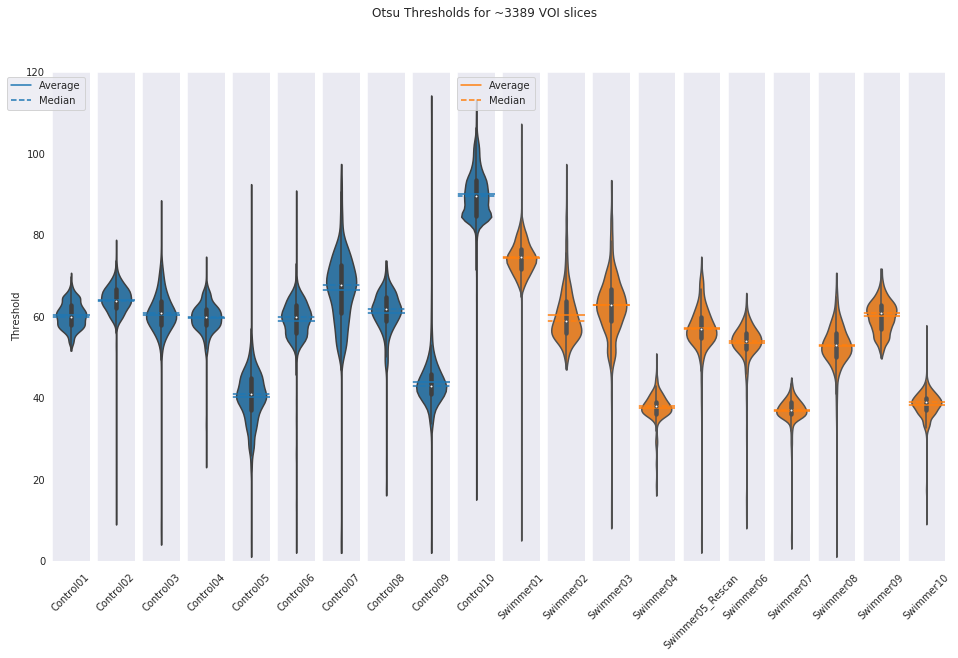

In [66]:
# Plot the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(1,len(Data), c+1)
    seaborn.violinplot(i[discard:-discard], orient='v', color=Data.Color[c], cut=0)    
#     seaborn.stripplot(i[discard:-discard], orient='v', color=Data.Color[c], jitter=True, linewidth=1, s=10, alpha=0.309)
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0,120])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Threshold')
    if '01' in Data.Sample[c]:
        plt.legend()
    plt.xlabel(Data.Sample[c], rotation=45)
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow )
plt.savefig(os.path.join(OutPutDir, 'Thresholds_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

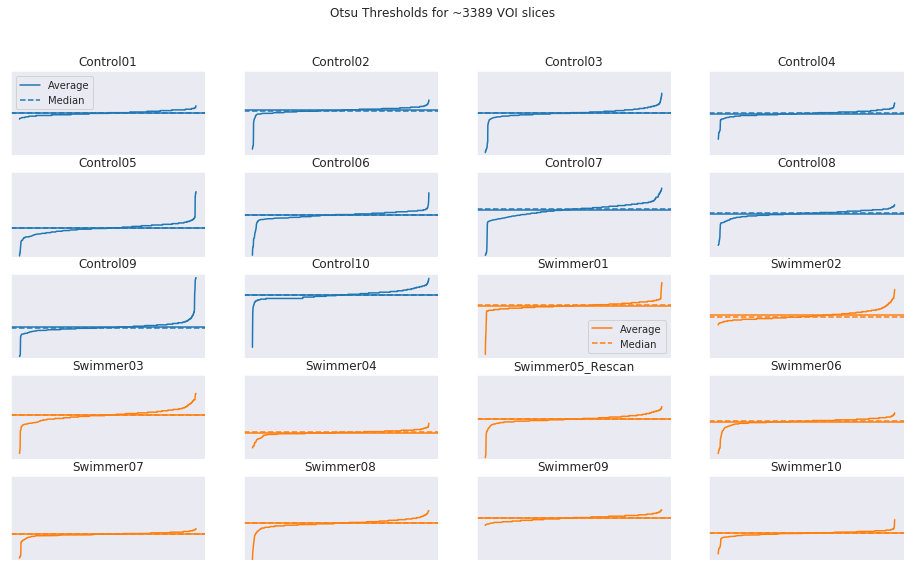

In [68]:
# Plot the Thresholds
for c, i in enumerate(Data.Threshold):
    plt.subplot(lines, numpy.ceil(len(Data) / float(lines)), c + 1)
    plt.plot(sorted(i[discard:-discard]), color=Data.Color[c])
    plt.axhline(Data.ThresholdAverage[c], label='Average', color=Data.Color[c])
    plt.axhline(Data.ThresholdMedian[c], label='Median', color=Data.Color[c], ls='dashed')
    plt.ylim([0,120])
    plt.title(Data.Sample[c])
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    if '01' in Data.Sample[c]:
        plt.legend()    
plt.suptitle('Otsu Thresholds for ~%s VOI slices' % NumberOfImagesToShow )
plt.savefig(os.path.join(OutPutDir, 'Thresholds-plot_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [69]:
# Read a subset of images
Data['OutputNameVOISubset'] = [os.path.join(f,
                                            sample +  '_VOI_subset_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                    len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it to the end :)
VOISubset = [numpy.nan for file in Data.OutputNameVOISubset]
for c, subset in enumerate(Data.OutputNameVOISubset):
    if len(Data.VOINames[c]) != len(Data.VOINames[c][::Data.PrintEverySlice[c]]):
        # We are using a subset
        # Only do this if we didn't do it already...
        if os.path.exists(subset):
            print('%2s/%s: %16s: Already saved to %s' % (c+1,
                                                         len(Data.Sample),
                                                         Data.Sample[c],
                                                         subset[len(RootFolder):]))
        else:
            print('%2s/%s: %16s: Subsetting %s of %s VOI images' % (c+1,
                                                                    len(Data.Sample),
                                                                    Data.Sample[c],
                                                                    len(Data.SubsetNames[c]),
                                                                    len(Data.VOINames[c])))
            VOISubset[c] = [numpy.nan] * len(Data.VOINames[c][::Data.PrintEverySlice[c]])
            for d, image in enumerate(VOIImages[c][::Data.PrintEverySlice[c]]):
                VOISubset[c][d] = image
            print('%23s: Saving subset to %s' % (Data.Sample[c], subset[len(RootFolder):]))                
            numpy.save(subset, VOISubset[c], allow_pickle=False)
            VOISubset[c] = numpy.nan
            gc.collect()
    else:
        # We are using the full dataset
        print('%2s/%s: %16s: Using the full dataset' % (c+1, len(Data.Sample), Data.Sample[c]))

 1/20:        Control01: Using the full dataset
 2/20:        Control02: Using the full dataset
 3/20:        Control03: Using the full dataset
 4/20:        Control04: Using the full dataset
 5/20:        Control05: Using the full dataset
 6/20:        Control06: Using the full dataset
 7/20:        Control07: Using the full dataset
 8/20:        Control08: Using the full dataset
 9/20:        Control09: Using the full dataset
10/20:        Control10: Using the full dataset
11/20:        Swimmer01: Using the full dataset
12/20:        Swimmer02: Using the full dataset
13/20:        Swimmer03: Using the full dataset
14/20:        Swimmer04: Using the full dataset
15/20: Swimmer05_Rescan: Using the full dataset
16/20:        Swimmer06: Using the full dataset
17/20:        Swimmer07: Using the full dataset
18/20:        Swimmer08: Using the full dataset
19/20:        Swimmer09: Using the full dataset
20/20:        Swimmer10: Using the full dataset


In [70]:
# Clear the memory
%xdel VOISubset

In [71]:
# Load (or memory-map) all the files.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [72]:
# Get the longest samplename, https://stackoverflow.com/a/21295630/323100
namelenmax = Data.Sample.str.len().max()

In [73]:
# Actually threshold the images
singlethreshold = True
if singlethreshold:
    Data['OutputNameThresholded'] = [os.path.join(f, 'VOI_thresholded-with-%0.2f.npy' % tm) for f, tm in zip(Data.Folder, Data.ThresholdAverage)]
else:
    Data['OutputNameThresholded'] = [os.path.join(f, 'VOI_thresholded-slicewise.npy') for f in Data.Folder]
Thresholded = [numpy.nan for file in Data.OutputNameThreshold]
for c, sample in Data.iterrows():
    # Only do this if we didn't do it already...
    if os.path.exists(sample.OutputNameThresholded):
        print('%2s/%s: %s: Already saved to %s' % (c+1, len(Data.Sample), sample.Sample.rjust(namelenmax), os.path.basename(sample.OutputNameThresholded)))
    else:
        print('%2s/%s: %s: Thresholding %3s VOI images' % (c+1, len(Data.Sample), sample.Sample.rjust(namelenmax), len(sample.VOINames)))
        Thresholded[c] = [None] * len(sample.VOINames)
        for d, image in enumerate(VOISubset[c]):
            if singlethreshold:
                Thresholded[c][d] = image > sample.Threshold[d]
            else:
                Thresholded[c][d] = image > sample.ThresholdAverage
        # Save the images to NumPy binary files, disallowing pickle for portability
        print('%s: Saving to %s' % (os.path.basename(sample.Sample.rjust(namelenmax + 7)), sample.OutputNameThresholded))
        numpy.save(sample.OutputNameThresholded, Thresholded[c], allow_pickle=False)
        Thresholded[c] = numpy.nan
        gc.collect()
if singlethreshold:
    print('\n\nWe were using a single threshold (ThresholdAverage) for *all* the images')
else:
    print('\n\nWe were using the Otsu threshold from each single image')

 1/20:        Control01: Already saved to VOI_thresholded-with-60.33.npy
 2/20:        Control02: Already saved to VOI_thresholded-with-63.97.npy
 3/20:        Control03: Already saved to VOI_thresholded-with-60.43.npy
 4/20:        Control04: Already saved to VOI_thresholded-with-59.55.npy
 5/20:        Control05: Already saved to VOI_thresholded-with-40.26.npy
 6/20:        Control06: Already saved to VOI_thresholded-with-58.81.npy
 7/20:        Control07: Already saved to VOI_thresholded-with-66.36.npy
 8/20:        Control08: Already saved to VOI_thresholded-with-60.89.npy
 9/20:        Control09: Already saved to VOI_thresholded-with-43.90.npy
10/20:        Control10: Already saved to VOI_thresholded-with-89.89.npy
11/20:        Swimmer01: Already saved to VOI_thresholded-with-74.24.npy
12/20:        Swimmer02: Already saved to VOI_thresholded-with-60.36.npy
13/20:        Swimmer03: Already saved to VOI_thresholded-with-62.66.npy
14/20:        Swimmer04: Already saved to VOI_thres

In [74]:
Thresholded = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameThresholded]

In [77]:
# Save thresholded images out
SaveImages = False
if SaveImages:
    # Save thresholded images
    for c, folder in enumerate(Data.VOIFolder):
        CurrentOutputFolder = os.path.join(folder, os.path.splitext(os.path.basename(Data.OutputNameThresholded[c]))[0])
        if not os.path.exists(CurrentOutputFolder):
            os.makedirs(CurrentOutputFolder)
        if len(glob.glob(os.path.join(CurrentOutputFolder, '*.png'))) >= len(VOIImages[c]):
            print('%2s/%s: %s: Already saved %s thresholded images to %s' % (c+1,
                                                                             len(Data),
                                                                             Data.Sample[c].rjust(namelenmax),
                                                                             len(VOIImages[c]),
                                                                             CurrentOutputFolder[len(RootFolder)+1:]))
        else:
            print('%2s/%s: %s: Saving %s thresholded images to %s' % (c+1,
                                                                      len(Data),
                                                                      Data.Sample[c].rjust(namelenmax),
                                                                      len(Thresholded[c]),
                                                                      CurrentOutputFolder[len(RootFolder)+1:]))
            for d, i in enumerate(Thresholded[c]):
                scipy.misc.imsave(os.path.join(CurrentOutputFolder,
                                               Data.Sample[c] + '_thresholded_%04d.png' % d), i.astype('uint8') * 255)

In [78]:
# # Display some original slices through the VOIs
# SlicesToShow = 5
# Iterator = [int(round(len(r)/SlicesToShow)) for r in Data.VOINames]
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(VOIImages[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_originals.png' % (sample.Sample, SlicesToShow)))
#     plt.show()

In [79]:
# # Display some thresholded slices through the VOIs
# for c, sample in Data.iterrows():
#     for i in range(SlicesToShow):
#         plt.subplot(1,SlicesToShow,i+1)
#         plt.imshow(Thresholded[c][::Iterator[c]][i])
#         plt.axis('off')
#         if i:
#             plt.title('Slice %s' % i)
#         else:
#             plt.gca().add_artist(ScaleBar(sample.PixelSize, 'um', color='white'))
#             plt.title(sample.Sample)
#     plt.savefig(os.path.join(OutPutDir, 'Sampler_%s_%s-images_thresholded.png' % (sample.Sample, SlicesToShow)))
#     plt.show()

In [80]:
# Read or generate the MIPs
Data['OutputNameMIP'] = [os.path.join(f,
                                      sample +  '_MIP_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                       len(n)))
                         for f, sample, n, p in zip(Data.Folder,
                                                    Data.Sample,
                                                    Data.VOINames,
                                                    Data.PrintEverySlice)]
MIPs = [None] * len(Data)
for c, fn in enumerate(Data.OutputNameMIP):
    if os.path.exists(fn):
        print('%2s/%s: %16s: Loading %s into memory' % (c+1, len(Data), Data.Sample[c], fn[len(RootFolder):]))
        MIPs[c] = numpy.load(fn, mmap_mode='r')
    else:
        print('%2s/%s: %16s: Generating MIP from %s images' % (c+1,
                                                               len(Data),
                                                               Data.Sample[c],
                                                               len(Data.SubsetNames[c])))        
        MIPs[c] = numpy.max(VOISubset[c], axis=0)
        numpy.save(fn, MIPs[c], allow_pickle=False)
        # Free up memory
        VOISubset[c]._mmap.close()
        gc.collect()
    # Save MIP to PNG image
    scipy.misc.imsave(os.path.splitext(fn)[0] + '.png', MIPs[c])        

 1/20:        Control01: Loading /Control01/Control01_MIP_from_2338_of_2338_slices.npy into memory
 2/20:        Control02: Loading /Control02/Control02_MIP_from_3062_of_3062_slices.npy into memory
 3/20:        Control03: Loading /Control03/Control03_MIP_from_3062_of_3062_slices.npy into memory
 4/20:        Control04: Loading /Control04/Control04_MIP_from_2452_of_2452_slices.npy into memory
 5/20:        Control05: Loading /Control05/Control05_MIP_from_2642_of_2642_slices.npy into memory
 6/20:        Control06: Loading /Control06/Control06_MIP_from_3389_of_3389_slices.npy into memory
 7/20:        Control07: Loading /Control07/Control07_MIP_from_2452_of_2452_slices.npy into memory
 8/20:        Control08: Loading /Control08/Control08_MIP_from_2400_of_2400_slices.npy into memory
 9/20:        Control09: Loading /Control09/Control09_MIP_from_2572_of_2572_slices.npy into memory
10/20:        Control10: Loading /Control10/Control10_MIP_from_2452_of_2452_slices.npy into memory
11/20:    

In [81]:
# # Display x,y,z-MIPs
# for c,sample in enumerate(VOISubset):
#     plt.imshow(numpy.max(sample, axis=1))
#     plt.title(Data.Sample[c])
#     plt.show()

In [82]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

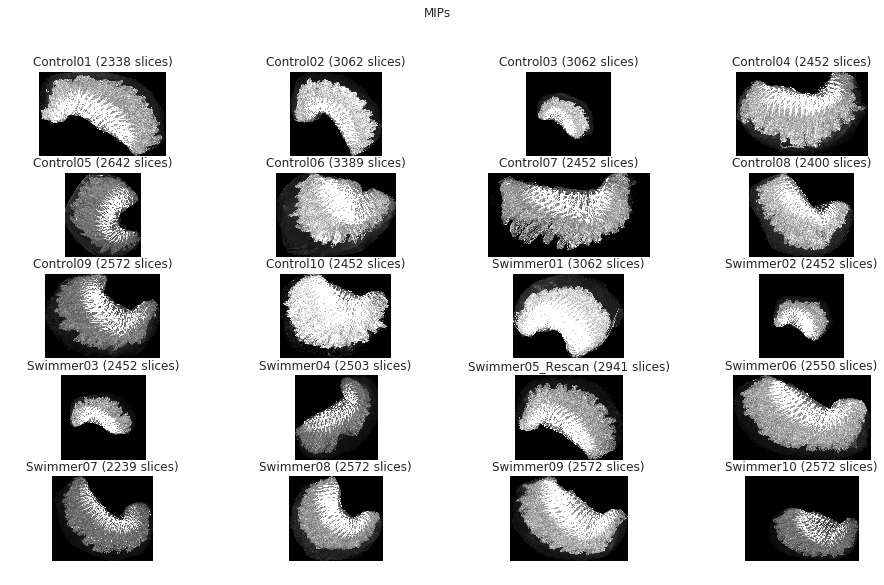

In [83]:
# Display 'through-the-sample' MIPs
for c, m in enumerate(MIPs):
    plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
    plt.imshow(m)
    try:
        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
    except:
        pass
    plt.title('%s (%s slices)' % (SampleNames[c], len(Data.SubsetNames[c])))
    plt.axis('off')
plt.suptitle('MIPs')
plt.savefig(os.path.join(OutPutDir, 'MIPs_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [84]:
# grab the thresholds in the 60-80% range of the respective values
split = 5
Selected = [sorted(t)[(split-2)*len(t)//split:(split-1)*len(t)//split] for t in Data.Threshold]
# mask the values of the threshold that are *not* in this range
Otsu_selected = [numpy.ma.masked_outside(o, numpy.min(sel), numpy.max(sel)) for o, sel in zip(Data.Threshold, Selected)]
# use the mean of this 60-80% value to threshold the datasets
GlobalThreshold = [numpy.nanmean(os) for os in Otsu_selected]

In [85]:
# FORCE THRESHOLD
# GlobalThreshold = [20 for t in GlobalThreshold]

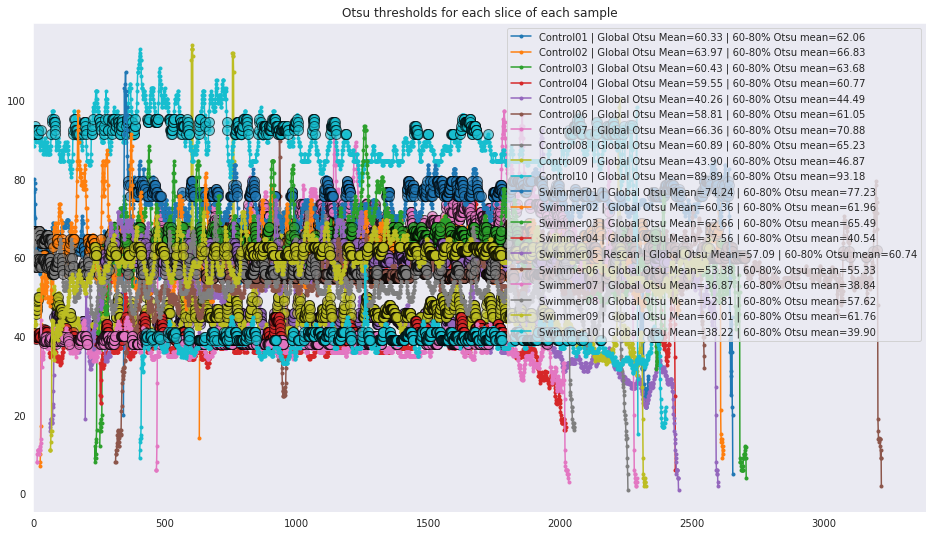

In [88]:
# Display the different thresholds
for c, s in enumerate(SampleNames):
    plt.plot(Data.Threshold[c], marker='.', label='%s | Global Otsu Mean=%.2f | 60-80%% Otsu mean=%0.2f' % (s,
                                                                                                            numpy.nanmean(Data.ThresholdAverage[c]),
                                                                                                            GlobalThreshold[c]),
             c=seaborn.color_palette(n_colors=len(SampleNames))[c])
    plt.plot(Otsu_selected[c], '.', ms=20, alpha=0.618, markeredgecolor='k', markeredgewidth=1, 
             c=seaborn.color_palette(n_colors=len(SampleNames))[c])
    plt.legend(loc='best')
plt.xlim([0, Data.NumberOfVOISlices.max()])
plt.title('Otsu thresholds for each slice of each sample')
plt.savefig(os.path.join(OutPutDir, 'Thresholds.png'))
plt.show()

In [89]:
# Compare global Otsu threshold, 60%-80% selected threshold and threshold from MIPs
for c,s in enumerate(SampleNames):
    print('For %s we have a' % s)
    print('\t- 60-80%% selected threshold of %0.2f' % GlobalThreshold[c])
    print('\t- global Otsu threshold of %0.2f' % Data.ThresholdAverage[c])

For Control01 we have a
	- 60-80% selected threshold of 62.06
	- global Otsu threshold of 60.33
For Control02 we have a
	- 60-80% selected threshold of 66.83
	- global Otsu threshold of 63.97
For Control03 we have a
	- 60-80% selected threshold of 63.68
	- global Otsu threshold of 60.43
For Control04 we have a
	- 60-80% selected threshold of 60.77
	- global Otsu threshold of 59.55
For Control05 we have a
	- 60-80% selected threshold of 44.49
	- global Otsu threshold of 40.26
For Control06 we have a
	- 60-80% selected threshold of 61.05
	- global Otsu threshold of 58.81
For Control07 we have a
	- 60-80% selected threshold of 70.88
	- global Otsu threshold of 66.36
For Control08 we have a
	- 60-80% selected threshold of 65.23
	- global Otsu threshold of 60.89
For Control09 we have a
	- 60-80% selected threshold of 46.87
	- global Otsu threshold of 43.90
For Control10 we have a
	- 60-80% selected threshold of 93.18
	- global Otsu threshold of 89.89
For Swimmer01 we have a
	- 60-80% select

In [90]:
# Show all (global) histograms
if not True:
    # This takes a while, since we 'ravel' all images from the subsets and calculate their histogram...
    for c, s in enumerate(SampleNames):
        plt.subplot(lines, numpy.ceil(len(SampleNames) / float(lines)), c + 1)
        plt.hist(numpy.array(VOISubset[c]).ravel(), bins=32, log=True, color=Data.Color[c], 
                 label='%s | %s VOI slices' % (s, len(VOISubset[c])))
        if CalculateAllThresholds:
            plt.axvline(GlobalThreshold[c],
                        label='Selected Threshold: %0.2f' % GlobalThreshold[c],
                        c=seaborn.color_palette()[2])
            plt.axvline(GlobalOtsu[c], label='Mean Otsu Threshold: %0.2f' % GlobalOtsu[c],
                        c=seaborn.color_palette()[3])
        plt.axvline(Otsu_MIP[c], label='MIP Otsu Threshold: %0.2f' % Otsu_MIP[c],
                    c=seaborn.color_palette()[4])
        plt.legend()
        plt.xlim([0, 255])
    plt.savefig(os.path.join(OutPutDir, 'Histograms_Thresholds_from%04dslices.png' % NumberOfImagesToShow))
    plt.show()

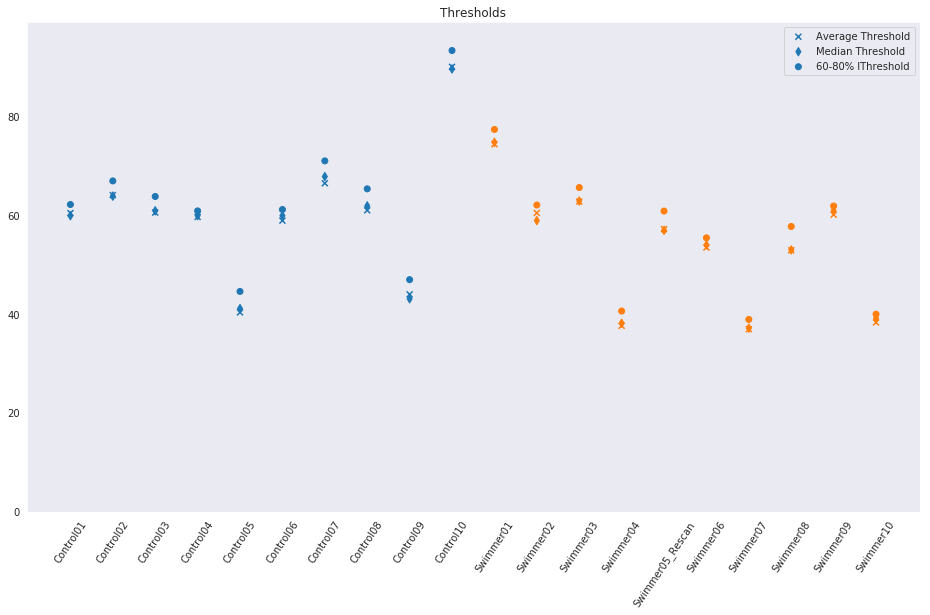

In [95]:
# Display the different thresholds
y_max = Data.ThresholdAverage.max() * 1.1
plt.scatter(x=Data.Sample, y=Data.ThresholdAverage, label='Average Threshold', c=Data.Color, marker='x')
plt.scatter(x=Data.Sample, y=Data.ThresholdMedian, label='Median Threshold', c=Data.Color, marker='d')
plt.scatter(x=Data.Sample, y=GlobalThreshold, label='60-80% lThreshold', c=Data.Color)
plt.legend()
plt.ylim([0,y_max])
plt.xticks(rotation=90*.618)    
plt.title('Thresholds')
plt.show()

In [96]:
# # Show middle images with some data
# plt.rcParams['figure.figsize'] = (16, 5)
# for c,s in enumerate(SampleNames):
#    maximum = skimage.filters.rank.maximum(Data.MiddleSlice[c].astype('uint8'), skimage.morphology.disk(25))
#    plt.subplot(141)
#    plt.imshow(Data.MiddleSlice[c])
#    try:
#        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
#    except:
#        pass
#    plt.title('Middle slice of %s' % s)
#    plt.subplot(142)
#    plt.imshow(Data.MiddleSlice[c], vmax=0.618*numpy.max(Data.MiddleSlice[c]))
#    plt.imshow(maximum, cmap='viridis', alpha=0.5)
#    try:
#        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))    
#    except:
#        pass
#    plt.title('%s with local maxima' % os.path.basename(Data.MiddleSliceName[c]))
#    plt.subplot(143)
#    plt.hist(Data.MiddleSlice[c].ravel(), bins=32, log=True, color=Data.Color[c])
#    if CalculateAllThresholds:
#        plt.axvline(GlobalThreshold[c], c=seaborn.color_palette()[1], label='Global Treshold@%0.2f' % GlobalThreshold[c])
#        plt.axvline(GlobalThreshold[c],
#                    label='Selected Threshold: %0.2f' % GlobalThreshold[c],
#                    c=seaborn.color_palette()[2])
#        plt.axvline(GlobalOtsu[c], label='Global Otsu Threshold: %0.2f' % GlobalOtsu[c],
#                    c=seaborn.color_palette()[3])        
#    plt.axvline(Otsu_MIP[c], c=seaborn.color_palette()[4], label='MIP Otsu Treshold: %0.2f' % Otsu_MIP[c])        
#    plt.legend(loc='best')
#    plt.xlim([0,255])
#    plt.title('Histogram of middle slice')
#    plt.subplot(144)
#    plt.imshow(MIPs[c])
#    plt.title('MIP of %s slices of %s' % (len(Data.SubsetNames[c]),
#                                          Data.Sample[c]))
#    try:
#        plt.gca().add_artist(ScaleBar(PixelSize[c], 'um'))
#    except:
#        pass
#    plt.savefig(os.path.join(OutPutDir, 'Details_%s.png' % Data.Sample[c]))
#    plt.show()
# plt.rcParams['figure.figsize'] = (16, 9)

In [97]:
def calculate_area_gills(image, threshold=None):
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    area_gills = numpy.sum(thresholded_image)
    return(area_gills)

In [98]:
# Calculate the gill area (pythonic way, but without saving it in the middle...)
# Data['AreaGills'] = [[calculate_area_gills(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [99]:
# Calculate the gill area (slow way, but with saving it in the middle...)
Data['OutputNameAreaGills'] = [os.path.join(f,
                                           sample +  '_area_gills_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaGills'] = [numpy.nan for file in Data.OutputNameAreaGills]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaGills[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c+1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaGills[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating gill area on %s of %s VOI images' % (c+1,
                                                                              len(Data.Sample),
                                                                              Data.Sample[c],
                                                                              len(Data.SubsetNames[c]),
                                                                              len(Data.VOINames[c])))
        Data.AreaGills[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            Data.AreaGills[c][d] = calculate_area_gills(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaGills[c][len(RootFolder):]))                
        numpy.save(Data.OutputNameAreaGills[c], Data.AreaGills[c], allow_pickle=False)
        Data.AreaGills[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_area_gills_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_area_gills_from_3062_of_3062_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_area_gills_from_3062_of_3062_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_area_gills_from_2452_of_2452_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_area_gills_from_2642_of_2642_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_area_gills_from_3389_of_3389_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_area_gills_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_area_gills_from_2400_of_2400_slices.npy
 9/20:        Control09: Already saved to /Control09/Control09_area_gills_from_2572_of_2572_slices.npy
10/20:        Control10: Already saved to /Control10/Control10_area_gills

In [100]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [101]:
# Save gills images out
for c, sample in Data.iterrows():
    sample['CurrentOutputFolder'] = os.path.join(os.path.dirname(sample.OutputNameVOI), 'VOI_thresholded_gills')
    if not os.path.exists(sample.CurrentOutputFolder):
        os.makedirs(sample.CurrentOutputFolder)
    if len(glob.glob(os.path.join(sample.CurrentOutputFolder, '*.png'))) >= sample.NumberOfAnalyzedVOISlices:
        print('%2s/%s: %7s: Already saved %3s thresholded images to %s' % (c+1,
                                                                           len(Data),
                                                                           sample.Sample,
                                                                           sample.NumberOfAnalyzedVOISlices,
                                                                           sample.CurrentOutputFolder[len(RootFolder):]))
    else:
        print('%2s/%s: %7s: Saving %3s thresholded images to the disk' % (c+1,
                                                                          len(Data),
                                                                          Data.Sample[c],
                                                                          sample.NumberOfAnalyzedVOISlices))
        for d, i in enumerate(VOISubset[c]):
            _ = i>Data.Threshold[c][d]
            scipy.misc.imsave(os.path.join(sample.CurrentOutputFolder,
                                           sample.Sample + '_thresholded_gills_%04d.png' % d), _.astype('uint8') * 255)

 1/20: Control01: Already saved 2338 thresholded images to /Control01/VOI_thresholded_gills
 2/20: Control02: Already saved 3062 thresholded images to /Control02/VOI_thresholded_gills
 3/20: Control03: Already saved 3062 thresholded images to /Control03/VOI_thresholded_gills
 4/20: Control04: Already saved 2452 thresholded images to /Control04/VOI_thresholded_gills
 5/20: Control05: Already saved 2642 thresholded images to /Control05/VOI_thresholded_gills
 6/20: Control06: Already saved 3389 thresholded images to /Control06/VOI_thresholded_gills
 7/20: Control07: Already saved 2452 thresholded images to /Control07/VOI_thresholded_gills
 8/20: Control08: Already saved 2400 thresholded images to /Control08/VOI_thresholded_gills
 9/20: Control09: Already saved 2572 thresholded images to /Control09/VOI_thresholded_gills
10/20: Control10: Already saved 2452 thresholded images to /Control10/VOI_thresholded_gills
11/20: Swimmer01: Already saved 3062 thresholded images to /Swimmer01/VOI_thresh

In [102]:
def calculate_area_organ(image, threshold=None, verbose=False):
    if not threshold:
        # Calculate the Otsu threshold of the image if needed
        try:
            threshold = skimage.filters.threshold_otsu(image)
        except (ValueError):
            threshold = 0
    thresholded_image = image > threshold
    binary_closing = True
    if binary_closing:
        # Use simple binary closing
        closed  = skimage.morphology.binary_closing(thresholded_image, selem=skimage.morphology.selem.disk(25))
    else:
        # Close small holes (this could be a bit more robust than simple binary closing)
        imagearea = numpy.shape(image)[0] * numpy.shape(image)[1] 
        closed  = skimage.morphology.remove_small_holes(thresholded_image, area_threshold=imagearea*.618)
    if verbose:
        # mask out Deas ROI
        masked = numpy.ma.masked_equal(image,0)
        # Show the images
        plt.subplot(131)
        plt.imshow(masked.filled(0))
        plt.axis('off')
        plt.title('Original')
        plt.subplot(132)
        plt.imshow(thresholded_image)
        plt.axis('off')
        plt.title('Thresholded with %0.2f: %0.2g px' % (threshold, numpy.sum(thresholded_image)))
        plt.subplot(133)
        plt.imshow(closed)
        plt.axis('off')
        plt.title('Closed: %0.2g px' % numpy.sum(closed))
        plt.show()
    area_organ = numpy.sum(closed)
    return(area_organ)

In [103]:
# Calculate the (extrapolated) organ area (pythonic way, but without saving it in the middle...)
# Data['AreaOrgan'] = [[calculate_area_organ(i, threshold=t)
#                       for i, t in zip(subset, thrs)]
#                      for subset, thrs in zip(VOISubset, Data.Threshold)]

In [104]:
# Calculate the (extrapolated) organ area (slow way, but with saving it in the middle...)
Data['OutputNameAreaOrgan'] = [os.path.join(f,
                                            sample +  '_area_organ_from_%04d_of_%04d_slices.npy' % (len(n[::p]),
                                                                                                   len(n)))
                               for f, sample, n, p in zip(Data.Folder,
                                                          Data.Sample,
                                                          Data.VOINames,
                                                          Data.PrintEverySlice)]
# Don't save into the dataframe, or else we won't be able to make it :)
Data['AreaOrgan'] = [numpy.nan for file in Data.OutputNameAreaOrgan]
for c, subset in enumerate(VOISubset):
    # Only do this if we didn't do it already...
    if os.path.exists(Data.OutputNameAreaOrgan[c]):
        print('%2s/%s: %16s: Already saved to %s' % (c+1,
                                                     len(Data.Sample),
                                                     Data.Sample[c],
                                                     Data.OutputNameAreaOrgan[c][len(RootFolder):]))
    else:
        print('%2s/%s: %16s: Calculating organ area on %s of %s VOI images' % (c+1,
                                                                               len(Data.Sample),
                                                                               Data.Sample[c],
                                                                               len(Data.SubsetNames[c]),
                                                                               len(Data.VOINames[c])))
        Data.AreaOrgan[c] = [None] * len(subset)
        for d, image in enumerate(subset):
            print('Working on image %04s of %04s' % (d, len(Data.SubsetNames[c])), end="\r")
            Data.AreaOrgan[c][d] = calculate_area_organ(image, threshold=Data.Threshold[c][d])
        print('%23s: Saving area to %s' % (Data.Sample[c], Data.OutputNameAreaOrgan[c][len(RootFolder):]))                
        numpy.save(Data.OutputNameAreaOrgan[c], Data.AreaOrgan[c], allow_pickle=False)
        Data.AreaOrgan[c] = numpy.nan
        # Free up memory
        subset._mmap.close()
        gc.collect()

 1/20:        Control01: Already saved to /Control01/Control01_area_organ_from_2338_of_2338_slices.npy
 2/20:        Control02: Already saved to /Control02/Control02_area_organ_from_3062_of_3062_slices.npy
 3/20:        Control03: Already saved to /Control03/Control03_area_organ_from_3062_of_3062_slices.npy
 4/20:        Control04: Already saved to /Control04/Control04_area_organ_from_2452_of_2452_slices.npy
 5/20:        Control05: Already saved to /Control05/Control05_area_organ_from_2642_of_2642_slices.npy
 6/20:        Control06: Already saved to /Control06/Control06_area_organ_from_3389_of_3389_slices.npy
 7/20:        Control07: Already saved to /Control07/Control07_area_organ_from_2452_of_2452_slices.npy
 8/20:        Control08: Already saved to /Control08/Control08_area_organ_from_2400_of_2400_slices.npy
 9/20:        Control09: Already saved to /Control09/Control09_area_organ_from_2572_of_2572_slices.npy
10/20:        Control10: Already saved to /Control10/Control10_area_organ

KeyboardInterrupt: 

In [105]:
# Load (or memory-map) all the files again, since we closed them above.
if Data.PrintEverySlice[0] == 1:
    # If we did NOT use a subset, load the original stack...
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOI]
else:
    # If we did use a subset, then load the subset
    VOISubset = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameVOISubset]

In [106]:
# Save organ area images out
for c, sample in Data.iterrows():
    sample['CurrentOutputFolder'] = os.path.join(os.path.dirname(sample.OutputNameVOI), 'VOI_organ_area')
    if not os.path.exists(sample.CurrentOutputFolder):
        os.makedirs(sample.CurrentOutputFolder)
    if len(glob.glob(os.path.join(sample.CurrentOutputFolder, '*.png'))) >= sample.NumberOfAnalyzedVOISlices:
        print('%2s/%s: %7s: Already saved %3s organ area images to %s' % (c+1,
                                                                          len(Data),
                                                                          sample.Sample,
                                                                          len(sample.ReconstructionNames),
                                                                          sample.CurrentOutputFolder[len(RootFolder):]))
    else:
        print('%2s/%s: %7s: Saving %3s organ area images to the disk' % (c+1,
                                                                         len(Data),
                                                                         Data.Sample[c],
                                                                         sample.NumberOfAnalyzedVOISlices))
        for d, i in enumerate(VOISubset[c]):
            thresholded = i>Data.Threshold[c][d]
            closed  = skimage.morphology.binary_closing(thresholded, selem=skimage.morphology.selem.disk(25))
            scipy.misc.imsave(os.path.join(sample.CurrentOutputFolder,
                                           sample.Sample + '_area_organ_%04d.png' % d), closed.astype('uint8') * 255)

 1/20: Control01: Saving 2338 organ area images to the disk


KeyboardInterrupt: 

In [107]:
Data['AreaGills'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaGills]
Data['AreaOrgan'] = [numpy.load(file, mmap_mode='r') for file in Data.OutputNameAreaOrgan]

FileNotFoundError: [Errno 2] No such file or directory: '/media/habi/Fast_SSD/Zebra-Fish_Matthias/Swimmer03/Swimmer03_area_organ_from_2452_of_2452_slices.npy'

In [108]:
Data['VolumeGills'] = [numpy.sum(ag) for ag in Data.AreaGills]
Data['VolumeOrgan'] = [numpy.sum(ao) for ao in Data.AreaOrgan]

TypeError: unsupported operand type(s) for +: 'NoneType' and 'NoneType'

In [109]:
Data['GillsPerOrgan'] = [numpy.divide(ag, ao) for (ag,ao) in zip(Data['AreaGills'], Data['AreaOrgan'])]

TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

In [110]:
# Boxplots of the Areas
for c, a in enumerate(Data.GillsPerOrgan):
    plt.subplot(1,len(Data), c+1)
    seaborn.violinplot(a, orient='v', color=Data.Color[c], cut=0)
#     seaborn.lvplot(a, orient='v', color=Data.Color[c])
#     seaborn.stripplot(a, orient='v', jitter=True, linewidth=1, s=5, color='gray', alpha=0.318)
    plt.ylim([0,1])
    if c:
        plt.gca().axes.yaxis.set_ticklabels([])
    else:
        plt.ylabel('Gills per organ ratio')
    plt.xlabel(Data.Sample[c], rotation=45)
plt.suptitle('"Gills per organ" ratio for ~%s VOI slices' % NumberOfImagesToShow )
plt.savefig(os.path.join(OutPutDir, 'Gills_per_organ_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

AttributeError: 'DataFrame' object has no attribute 'GillsPerOrgan'

In [111]:
Data['Mean_from_Area'] = [float(numpy.nanmean(a)) for a in Data['GillsPerOrgan']]
Data['Mean_from_Volume'] = [numpy.divide(gv, ov) for gv, ov in zip(Data.VolumeGills, Data.VolumeOrgan)]

KeyError: 'GillsPerOrgan'

In [112]:
# Boxplot of the mean area for each animal (calculated slice-wise)
seaborn.boxplot(data=Data, x='Experiment', y='Mean_from_Area')
seaborn.swarmplot(data=Data, x='Experiment', y='Mean_from_Area', s=15, linewidth=1)
label=True
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Mean_from_Area[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Mean_from_Area[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Average "gills per organ" from slices')
plt.savefig(os.path.join(OutPutDir, 'Gills_per_organ_average_slices_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

ValueError: Could not interpret input 'Mean_from_Area'

In [113]:
# Boxplot of the ratio of the gill volume to the organ volume
seaborn.boxplot(data=Data, x='Experiment', y='Mean_from_Volume')
seaborn.swarmplot(data=Data, x='Experiment', y='Mean_from_Volume', s=15, linewidth=1)
label=True
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Mean_from_Volume[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Mean_from_Volume[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Average "gills per organ" from volume')
plt.savefig(os.path.join(OutPutDir, 'Gills_per_organ_average_volume_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

ValueError: Could not interpret input 'Mean_from_Volume'

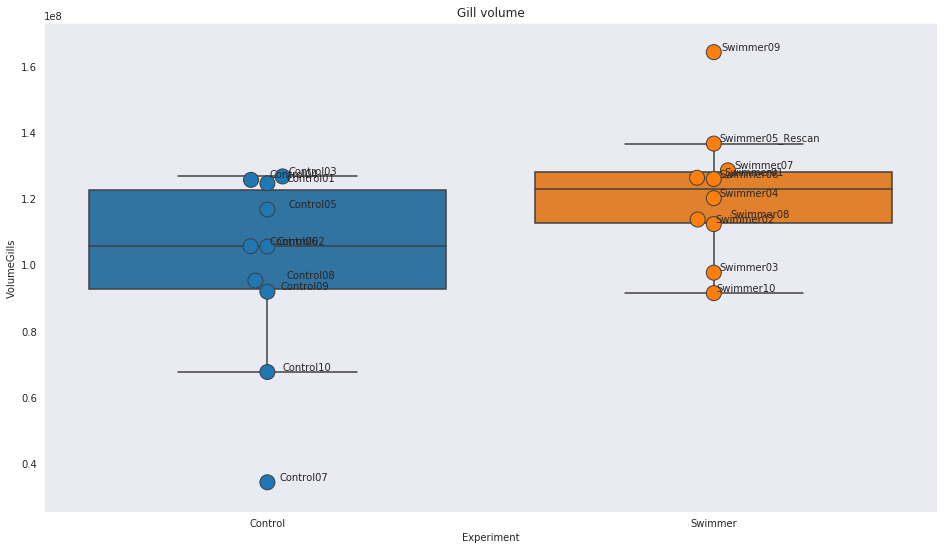

In [116]:
# Boxplot of the gills volume for each animal
seaborn.boxplot(data=Data, x='Experiment', y='VolumeGills')
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGills', s=15, linewidth=1)
label=True
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGills[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGills[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Gill volume')
plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [124]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGills)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9144847393035889, 0.07763797044754028)

In [125]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.5468692212197214, pvalue=0.46913511203835245)

In [126]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGills)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.4, pvalue=0.3128526760169558)

In [127]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGills,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGills,
                                             equal_var=True)  
print ("The difference between the 'gll volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'gll volume' of 'Control' and 'Swimmer' has an
F value of -1.9 and a p value of 0.032.


In [128]:
Data['VolumeGillsNormalized'] = [numpy.divide(gv, w) for gv, w in zip(Data.VolumeGills, Data.Length)]

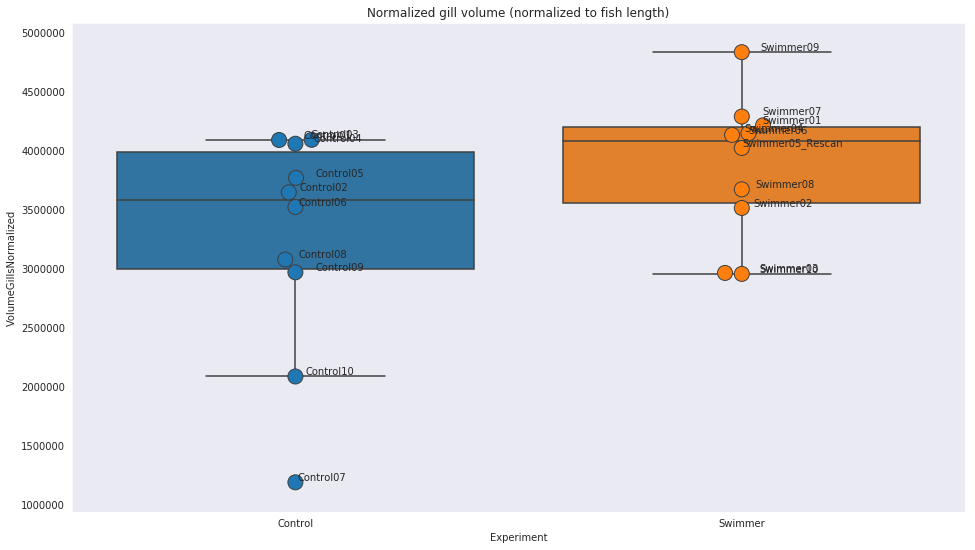

In [129]:
# Boxplot of the NORMALIZED gill volumes
seaborn.boxplot(data=Data, x='Experiment', y='VolumeGillsNormalized')
seaborn.swarmplot(data=Data, x='Experiment', y='VolumeGillsNormalized', s=15, linewidth=1)
label=True
if label:
    shift = 0.05
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Normalized gill volume (normalized to fish length)')
plt.savefig(os.path.join(OutPutDir, 'Volume_Gills_Normalized_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [130]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(Data.VolumeGillsNormalized)
# nicht signifikant von Normalverteilung unterschiedlich

(0.8843751549720764, 0.02122529409825802)

In [131]:
# Levene -> Varianztest
scipy.stats.levene(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                   Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.7616365992246344, pvalue=0.3943101021172065)

In [132]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                     Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.5, pvalue=0.11084033741322809)

In [133]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(Data.loc[Data.Experiment == 'Control'].VolumeGillsNormalized,
                                             Data.loc[Data.Experiment == 'Swimmer'].VolumeGillsNormalized,
                                             equal_var=True)  
print ("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an
F value of -1.7 and a p value of 0.049.


In [134]:
# Drop outliers
# TODO: Why do we do this?
WithoutOutliers = Data[(Data.Sample != 'Control07')]

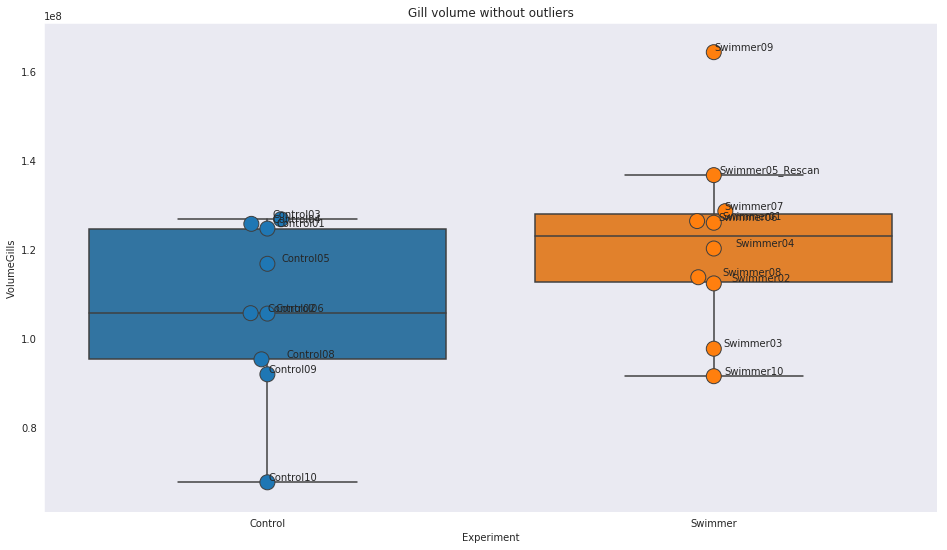

In [135]:
# Boxplot of the gill volumes without outliers
seaborn.boxplot(data=WithoutOutliers, x='Experiment', y='VolumeGills')
seaborn.swarmplot(data=WithoutOutliers, x='Experiment', y='VolumeGills', s=15, linewidth=1)
label=True
if label:
    shift = 0.05
    for c, row in WithoutOutliers.iterrows():
        if WithoutOutliers.Experiment[c] == 'Control':
            plt.gca().annotate(WithoutOutliers.Sample[c], (0 + shift * numpy.random.rand(),
                                                WithoutOutliers.VolumeGills[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(WithoutOutliers.Sample[c], (1 + shift * numpy.random.rand(),
                                                WithoutOutliers.VolumeGills[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Gill volume without outliers')
plt.savefig(os.path.join(OutPutDir,
                         'Volume_Gills_WithoutOutliers_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [136]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].VolumeGills,
                                             WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].VolumeGills,
                                             equal_var=True)  
print ("The difference between the 'gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'gill volume' of 'Control' and 'Swimmer' has an
F value of -1.6 and a p value of 0.06.


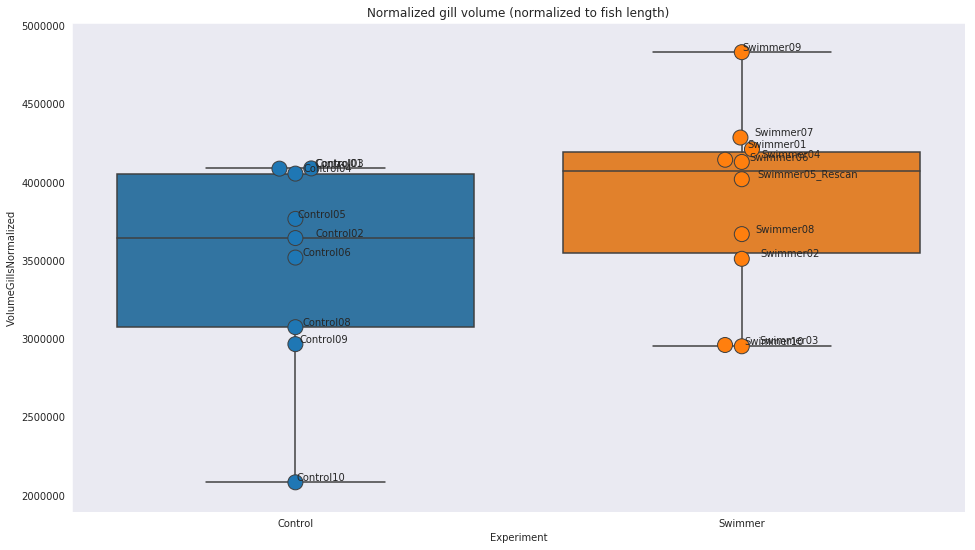

In [137]:
# Boxplot of the NORMALIZED gill volumes without outliers
seaborn.boxplot(data=WithoutOutliers, x='Experiment', y='VolumeGillsNormalized')
seaborn.swarmplot(data=WithoutOutliers, x='Experiment', y='VolumeGillsNormalized', s=15, linewidth=1)
label=True
if label:
    shift = 0.05
    for c, row in WithoutOutliers.iterrows():
        if WithoutOutliers.Experiment[c] == 'Control':
            plt.gca().annotate(WithoutOutliers.Sample[c], (0 + shift * numpy.random.rand(),
                                                WithoutOutliers.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(WithoutOutliers.Sample[c], (1 + shift * numpy.random.rand(),
                                                WithoutOutliers.VolumeGillsNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Normalized gill volume (normalized to fish length)')
plt.savefig(os.path.join(OutPutDir,
                         'Volume_Gills_Normalized_WithoutOutliers_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

In [138]:
# Shapiro -> Normalitätstest
scipy.stats.shapiro(WithoutOutliers.VolumeGillsNormalized)
# nicht signifikant von Normalverteilung unterschiedlich

(0.9343034029006958, 0.20776903629302979)

In [139]:
# Levene -> Varianztest
scipy.stats.levene(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].VolumeGillsNormalized,
                   WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].VolumeGillsNormalized)
# nicht signifikant -> Wahrscheinlich nicht nicht normalverteilt

LeveneResult(statistic=0.029412013973830253, pvalue=0.8658560400930828)

In [140]:
# Compute the Kolmogorov-Smirnov statistic on 2 samples -> Verteilungen nicht unterschiedlich?
scipy.stats.ks_2samp(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].VolumeGillsNormalized,
                     WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].VolumeGillsNormalized)
# knapp nicht signifikant -> wahrscheinlich nicht unterschiedliche Verteilung --> equal_var=True

Ks_2sampResult(statistic=0.5, pvalue=0.12729531248221598)

In [141]:
# Are the means different?
t_statistic, p_value = scipy.stats.ttest_ind(WithoutOutliers.loc[WithoutOutliers.Experiment == 'Control'].VolumeGillsNormalized,
                                             WithoutOutliers.loc[WithoutOutliers.Experiment == 'Swimmer'].VolumeGillsNormalized,
                                             equal_var=True)  
print ("The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an")
# Two-sided test done, but we want one-sided test --> p_value / 2 (only because we tested it above)
print ('F value of %0.4s and a p value of %.2g.' % (t_statistic, p_value / 2))

The difference between the 'normalized gill volume' of 'Control' and 'Swimmer' has an
F value of -1.3 and a p value of 0.095.


In [142]:
Data['Mean_from_VolumeNormalized'] = [numpy.divide(mv, w) for mv, w in zip(Data.Mean_from_Volume, Data.Length)]

AttributeError: 'DataFrame' object has no attribute 'Mean_from_Volume'

In [143]:
# Boxplot of the ratio of the NORMALIZED gill volume to the organ volume
seaborn.boxplot(data=Data, x='Experiment', y='Mean_from_VolumeNormalized')
seaborn.swarmplot(data=Data, x='Experiment', y='Mean_from_VolumeNormalized', s=15, linewidth=1)
label=True
if label:
    shift = 0.1
    for c, row in Data.iterrows():
        if Data.Experiment[c] == 'Control':
            plt.gca().annotate(Data.Sample[c], (0 + shift * numpy.random.rand(),
                                                Data.Mean_from_VolumeNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(Data.Sample[c], (1 + shift * numpy.random.rand(),
                                                Data.Mean_from_VolumeNormalized[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.title('Average volume')
plt.savefig(os.path.join(OutPutDir, 'Volumes_Average_Normalized_from%04dslices.png' % NumberOfImagesToShow))
plt.show()

ValueError: Could not interpret input 'Mean_from_VolumeNormalized'

In [144]:
# Boxplot of the mean area for each animal
seaborn.boxplot(data=WithoutOutliers, x='Experiment', y='Mean_from_Area')
seaborn.swarmplot(data=WithoutOutliers, x='Experiment', y='Mean_from_Area', s=15, linewidth=1)
label = True
if label:
    shift = 0.05
    for c, row in WithoutOutliers.iterrows():
        if WithoutOutliers.Experiment[c] == 'Control':
            plt.gca().annotate(WithoutOutliers.Sample[c], (0+shift,WithoutOutliers.Mean_from_Area[c]),
                               horizontalalignment='left', verticalalignment='bottom')         
        else:
            plt.gca().annotate(WithoutOutliers.Sample[c], (1+shift,WithoutOutliers.Mean_from_Area[c]),
                               horizontalalignment='left', verticalalignment='bottom')
plt.savefig(os.path.join(OutPutDir, 'Areas_Average_from%04dslices.png' % NumberOfImagesToShow))
plt.title('Area without Outliers')
plt.show()

ValueError: Could not interpret input 'Mean_from_Area'

In [145]:
# Save data at the end
Data.to_csv('Data_%s.csv' % get_git_hash())
Data.to_csv(os.path.join(OutPutDir, 'Data_%s.csv' % get_git_hash()))

In [146]:
# Save data at the end
WithoutOutliers.to_csv('Data_without_outliers_%s.csv' % get_git_hash())
WithoutOutliers.to_csv(os.path.join(OutPutDir, 'Data_without_outliers_%s.csv' % get_git_hash()))

In [147]:
print('All data has been saved to %s' % os.path.join(OutPutDir))

All data has been saved to /home/habi/P/Documents/Zebrafish-Gills/Output/82436ab


In [148]:
print('Done!')

Done!
